# Libraires

In [1]:
# import json file called config
import json
with open('config.json') as f:
    config = json.load(f)
TOKENIZER_ID = config['TOKENIZER_ID']

nrows = None if config['nrows'] == 0 else config['nrows']

In [2]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.linear_model import PassiveAggressiveClassifier #used to train the model
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score, confusion_matrix, roc_auc_score, roc_curve # this is used to evaluate the model.
from sklearn.model_selection import train_test_split # to separate the dataset.
from sklearn.feature_extraction.text import TfidfVectorizer #used for the transformation of text data.
import pickle as pkl #file to save and load a model.
from sklearn.model_selection import GridSearchCV #pour l'optimisation des hyperparametres.
import time #pour étudier le temps d'execution d'entrainement, de notre meilleure modèle.
import psutil #pour calculer la mémoire.
import os #pour calculer le temps d'execution.

# Load Data

In [3]:
data=pd.read_csv('x_y_dataset.csv',nrows=nrows)
X = data['X']
y = data['y']

# Convert the string representation of the list into a list of integers
import ast
X = X.apply(lambda x: ast.literal_eval(x))

# Convert the list of lists into a numpy array
X = np.array(X.tolist())
y = data['y']

X = np.array(X)
y = np.array(y)

# Modification du text en données numériques.
Nous partons du principe que les données ont étés clean et que nous pouvons nous concerntrer à créer un model.

Comme les informations principales pour définir des Fake news et des vrai news, se base sur le texte et le titre, nous devons nous focaliser sur ces informations. Il faut ainsi que nous transformons le text et le titre en données afin que notre model puisse utiliser des données numériques pour trouver la bonne réponse. Nous allons utiliser la methode de bert-.
# Bert tokenizer

In [4]:
# we separate the trdata into training test and validation
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [5]:
X_train = np.array(X_train.tolist())
y_train= np.array(y_train.tolist())
X_train.shape,y_train.shape

((26620, 512), (26620,))

In [6]:
X_test = np.array(X_test.tolist())
y_test= np.array(y_test.tolist())
X_test.shape,y_test.shape

((8319, 512), (8319,))

# Model Passive Agressive

Quand on parle d'un model passive aggressive, nous parlons d'un algorithme linéaire de classification et de regression. C'est un algorithme d'apprentissage en ligne, Il traite les données séquentiellement, ajustant le prédicteur à chaque nouvelle instance pour améliorer la prédiction future.

Le modèle se base sur deux principes:
- **Passive**: Si notre modèle prédit une instance juste, alors les poids et les biais ne seront pas changés. L'état actuelle de notre modèle sera maintenu.
- **Aggressive**: Si notre modèle fait une mauvaise prédiction sur une instance ressus, les poids et biais de notre modèle seront changés par le paramètre de régularisation **C**, le but étant de minimiser l'erreur. Il change les paramètres pour que la prédiction actuelle soit 'just'.

Le modèle utilise par défaut la fonction de cout **hinge**. Voici comment mathématiquement les poids et bias seront changés:

$$ w_{\text{new}} = w + \alpha y x $$
$$ b_{\text{new}} = b + \alpha y $$

où **w** est le vecteur de poids, **b** est le biais, **x** est le vecteur de caractéristiques de l'instance mal classée, **y** est l'étiquette correcte de l'instance, et **α** est le taux d'apprentissage calculé en fonction de l'erreur et du paramètre de régularisation **C**

Comme nous traitons des données de texte, et que nous devons faire une classification binaire, il ce va de dire que les text vont avoir des pattern differents, en utilisant le model passive aggressive, nous pouvons entrainer le model à définir une méthode pour les idenfifier.

In [7]:
# we build our model: C is the regulation parameter, and denotes the penalization the model will make on an incorrect prediciton.
model = PassiveAggressiveClassifier(C = 0.2, 
                                    random_state = 42,
                                    early_stopping=True,# we enable the early stopping procedure.
                                    n_iter_no_change=3, #number of iterations before early stopping
                                    verbose=True,
                                    loss='hinge', #fonction de cout
                                   )


In [8]:
#on entraine le model sur les données d'entrainement.
model.fit(X_train,y_train)
#Create or open a file with write-binary mode and save the model to it

-- Epoch 1
Norm: 0.00, NNZs: 512, Bias: 0.000001, T: 23958, Avg. loss: 1.187026
Total training time: 0.04 seconds.
-- Epoch 2
Norm: 0.00, NNZs: 512, Bias: 0.000002, T: 47916, Avg. loss: 1.189092
Total training time: 0.07 seconds.
-- Epoch 3
Norm: 0.00, NNZs: 512, Bias: 0.000002, T: 71874, Avg. loss: 1.202387
Total training time: 0.11 seconds.
-- Epoch 4
Norm: 0.00, NNZs: 512, Bias: 0.000003, T: 95832, Avg. loss: 1.199592
Total training time: 0.15 seconds.
-- Epoch 5
Norm: 0.00, NNZs: 512, Bias: 0.000004, T: 119790, Avg. loss: 1.190219
Total training time: 0.19 seconds.
Convergence after 5 epochs took 0.19 seconds


PassiveAggressiveClassifier(C=0.2, early_stopping=True, n_iter_no_change=3,
                            random_state=42, verbose=True)

In [9]:
#on sort les predictions
#Step 2: Open the saved file with read-binary mode
y_pred=model.predict(X_test)
y_pred.shape

(8319,)

# Optimisation

Pour optimiser le model nous allons modifier les paramètres suivants:
- **C (Le paramètre de régularisation)**: Un des paramètres les plus importants de l'algorithme passive aggressive. Il est utilisé pour controler la marge d'erreur que notre modèle est près à accepté. Si on lui donne une valeur de plus en plus élevé il se peut que le modèle suraprenne, car il s'adapte mieux aux données d'entrainement. Ainsi une valeur plus faible serait favorable. Nous allons tester C avec les valeurs suivantes: **[0.01,0.05,0.1,0.5,1]**

In [10]:
params_grid={'C':[0.01,0.05,0.1,0.5,1,5,10,50,100,250],
                'n_iter_no_change':[3,5,7],
                'loss':['hinge','squared_hinge']
             }

In [11]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.metrics import make_scorer, accuracy_score


# Initialize the Passive Aggressive Classifier
model = PassiveAggressiveClassifier(random_state=42,early_stopping=True)

# On creer un scorer pour le grid search 
scorer = make_scorer(accuracy_score)

# Initialisation de la GridSearch pour trouver le meilleur C.
grid_search = GridSearchCV(estimator=model, param_grid=params_grid, scoring=scorer, cv=5)

# On lance les multiples entrainements.
grid_search.fit(X_train, y_train)


GridSearchCV(cv=5,
             estimator=PassiveAggressiveClassifier(early_stopping=True,
                                                   random_state=42),
             param_grid={'C': [0.01, 0.05, 0.1, 0.5, 1, 5, 10, 50, 100, 250],
                         'loss': ['hinge', 'squared_hinge'],
                         'n_iter_no_change': [3, 5, 7]},
             scoring=make_scorer(accuracy_score, response_method='predict'))

In [12]:
# Get the best combination of parameters
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print(f"Best parameters: {best_params}")
print(f"Best score: {best_score}")


Best parameters: {'C': 0.01, 'loss': 'hinge', 'n_iter_no_change': 7}
Best score: 0.58809166040571


# Model Evaluation

Afin d'évaluer le modèle nous faisons une représentation graphique des résultats obtenus. Nous allons étudier les metrics suivants:
- le **temps d'entrainement** que le modèle a besoin, ainsi que son **taux de mémoire (Mo)**.
- **matrice de confusion**, qui est un excellent choix d'évaluation de performance, car nous sommes dans le cas d'une classification binaire. 
- **L'accuracy** du model.
- **La précision**
- **recall**
- **F1-score**.
- **ROC-AUC score**

src: https://www.v7labs.com/blog/performance-metrics-in-machine-learning#h2

In [13]:
#creation du modèle avec les meilleurs paramètres
best_model=PassiveAggressiveClassifier( 
                                        C=best_params['C'],
                                        n_iter_no_change=best_params['n_iter_no_change'],
                                        loss=best_params['loss'],
                                        early_stopping=True,
                                        verbose=True,
                                        random_state=42
                                    )

Nous voullons étudier **le temps d'entrainement (en h/m/s)** et **l'utilisation de la mémoire (Mo)** que le modèle a besoin.

In [14]:
def second_to_hms(seconds):
    hours = seconds // 3600
    minutes = (seconds % 3600) // 60
    seconds = seconds % 60
    return int(hours), int(minutes), int(seconds)

def bytes_to_Mo(mem_bytes):
    mem_kb = mem_bytes / 1024  # Convertir en kilooctets
    mem_mb = mem_kb / 1024  # Convertir en mégaoctets
    return mem_mb

In [15]:
#lancemenet de l'enrestristrement de la mémoire.
process = psutil.Process(os.getpid())
mem_before_bytes = process.memory_info().rss

#lancement de l'enregistrement du temps d'entrainement.
start_time = time.time() 
# entrainement du modèle.
best_model.fit(X_train,y_train)
end_time = time.time()

#le temps écoulé 
elapsed_time= end_time - start_time

print(f"Temps d'entrainement (h | m | s) : {second_to_hms(elapsed_time)[0]} | {second_to_hms(elapsed_time)[1]} | {second_to_hms(elapsed_time)[2]}")

mem_after_bytes = process.memory_info().rss
#on convertit les bytes en Mo.
mem_bytes=mem_after_bytes - mem_before_bytes


print(f"Utilisation de la mémoire (Mo) : {bytes_to_Mo(mem_bytes)}")

-- Epoch 1
Norm: 0.00, NNZs: 512, Bias: 0.000001, T: 23958, Avg. loss: 1.187026
Total training time: 0.04 seconds.
-- Epoch 2
Norm: 0.00, NNZs: 512, Bias: 0.000002, T: 47916, Avg. loss: 1.189092
Total training time: 0.08 seconds.
-- Epoch 3
Norm: 0.00, NNZs: 512, Bias: 0.000002, T: 71874, Avg. loss: 1.202387
Total training time: 0.12 seconds.
-- Epoch 4
Norm: 0.00, NNZs: 512, Bias: 0.000003, T: 95832, Avg. loss: 1.199592
Total training time: 0.16 seconds.
-- Epoch 5
Norm: 0.00, NNZs: 512, Bias: 0.000004, T: 119790, Avg. loss: 1.190219
Total training time: 0.24 seconds.
-- Epoch 6
Norm: 0.00, NNZs: 512, Bias: 0.000005, T: 143748, Avg. loss: 1.175401
Total training time: 0.29 seconds.
-- Epoch 7
Norm: 0.00, NNZs: 512, Bias: 0.000005, T: 167706, Avg. loss: 1.190660
Total training time: 0.35 seconds.
-- Epoch 8
Norm: 0.00, NNZs: 512, Bias: 0.000006, T: 191664, Avg. loss: 1.203768
Total training time: 0.39 seconds.
-- Epoch 9
Norm: 0.00, NNZs: 512, Bias: 0.000007, T: 215622, Avg. loss: 1.17

Le modèle utilise donc 0.00390625 Mo pour l'entrainement.

In [16]:
#optention des prédictions de ce modèle.
y_pred=best_model.predict(X_test)
y_pred.shape,y_test.shape

((8319,), (8319,))

Nous déterminons la **matrice de confusion**.

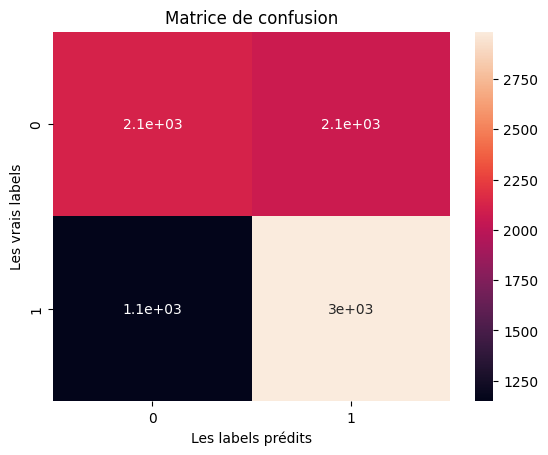

In [17]:
#creation de la matrice de confusion
cm = confusion_matrix(y_test, y_pred)

#représentation graphique du résultat du meilleure model
sns.heatmap(cm, annot=True)
plt.xlabel('Les labels prédits')
plt.ylabel('Les vrais labels')
plt.title('Matrice de confusion')
plt.show()

In [18]:
#we print the percentage of True Positive, True Negative, False Positive and False Negative
tn, fp, fn, tp = cm.ravel()
total_samples = tn + fp + fn + tp
true_negative_percentage = (tn / total_samples) * 100
false_positive_percentage = (fp / total_samples) * 100
false_negative_percentage = (fn / total_samples) * 100
true_positive_percentage = (tp / total_samples) * 100

print(f"True Negative: {true_negative_percentage}%")
print(f"False Positive: {false_positive_percentage}%")
print(f"False Negative: {false_negative_percentage}%")
print(f"True Positive: {true_positive_percentage}%")

True Negative: 25.447770164683252%
False Positive: 24.87077773770886%
False Negative: 13.799735545137636%
True Positive: 35.88171655247025%


In [19]:
print(f"le modèle a donc {cm[0][0]} instances vrai Positives et {cm[1][1]} instances de Vrai négatives, {cm[1][0]} instances de Faux Positives et {cm[0][1]} instances de Faux négatives. ")

le modèle a donc 2117 instances vrai Positives et 2985 instances de Vrai négatives, 1148 instances de Faux Positives et 2069 instances de Faux négatives. 


Nous allons avant tout calculer **la précision globale (accuracy)** de notre modèle. 

In [20]:
acc=accuracy_score(y_pred,y_test)
acc
print(f"Notre modèle a une accuracy de {round(acc*100,2)}%, ce qui signifie qu'il a bien prédit {round(acc*100,2)}% des instances de notre jeu de test.")

Notre modèle a une accuracy de 61.33%, ce qui signifie qu'il a bien prédit 61.33% des instances de notre jeu de test.


on calcul le **precision**, c'est la capacité du modèle à correctement identifier les instances que nous avons prédits. Donc de prédire qu'une News vrai soit vraie.

In [21]:
precision=precision_score(y_test,y_pred)
precision
print(f"notre model a une precision de {round(precision*100,2)}% . lorsqu'il prédit une classe comme positive, il a raison dans {round(precision*100,2)}% des cas.")

notre model a une precision de 59.06% . lorsqu'il prédit une classe comme positive, il a raison dans 59.06% des cas.


on calcul le **recall**, ce qui es le pourcentage de Vrai positif **(dans notre cas les Vrai news)** que notre modèle arrive à prédire.

In [22]:
recall=recall_score(y_test,y_pred)
recall
print(f"notre model a un recall de {round(recall*100,2)}% . notre model a pu détecter {round(recall*100,2)}% des vrais positifs.")

notre model a un recall de 72.22% . notre model a pu détecter 72.22% des vrais positifs.


On calcule le **F1-score**, c'est une combinaison de la précision et du recall, en calculant la moyenne harmonique entre les deux. Son but est **d'étudier l'équilibre entre la precision et le recall.**

In [23]:
f1score=f1_score(y_test,y_pred)
f1score

if f1score<0.5:
    print(f"notre model a un f1 score de {round(f1score*100,2)}% . Ce qui est une performance moyenne.")
else:
    print(f"notre model a un f1 score de {round(f1score*100,2)}% . Ce qui est une bonne performance.")

notre model a un f1 score de 64.98% . Ce qui est une bonne performance.


## Courbe ROC-AUC
Dans le contexte d'une classification binaire, il est essentiel d'utiliser la courbe ROC-AUC pour évaluer notre modèle. Nous allons examiner deux aspects :

- **ROC (Receiver Operating Characteristic)**: Cette courbe illustre le rapport entre le taux de vrais positifs et le taux de faux positifs. Elle permet de visualiser la capacité du modèle à discriminer entre les deux classes.

- **AUC (Area Under the Curve)**: C'est une mesure qui résume la courbe ROC en calculant l'aire sous celle-ci et au-dessus de la diagonale qui va du coin inférieur gauche au coin supérieur droit du graphique. Un score AUC proche de 1 indique que notre modèle fait des prédictions presque parfaites. En revanche, un score proche de 0,5 suggère que nos prédictions sont principalement due au hasard, ce qui signifie que le modèle n'apprend pas de manière efficace.

L'objectif de ces mesures est de déterminer à quel point notre modèle est efficace dans la tâche de classification binaire.

On définit le score ROC-AUC.

In [24]:
roc_auc=roc_auc_score(y_test,y_pred)
roc_auc
print(f"notre model a un roc_auc de {round(roc_auc*100,2)}% . Cela signifie que notre modèle a une capacité de {round(roc_auc*100,2)}% à distinguer les classes positives et négatives.")

notre model a un roc_auc de 61.4% . Cela signifie que notre modèle a une capacité de 61.4% à distinguer les classes positives et négatives.


avec une telle valeur, nous pouvons considerer que notre model n'est pas optimale à distinguer les vrai news des faux.

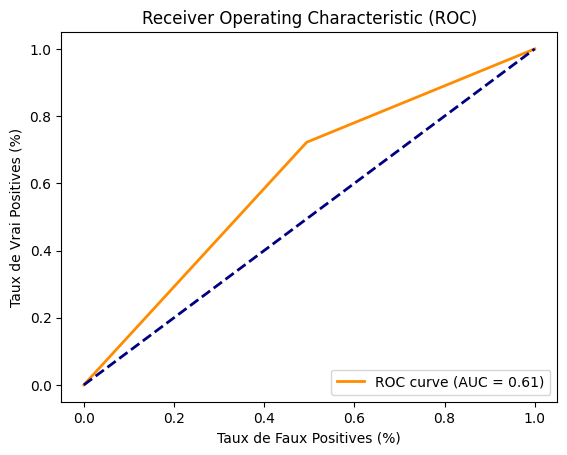

In [25]:
fpr, tpr, _ = roc_curve(y_test, y_pred)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('Taux de Faux Positives (%)')
plt.ylabel('Taux de Vrai Positives (%)')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

L'axe des abscisses (axe x) représente le taux de faux positifs, c'est-à-dire le pourcentage de vraies nouvelles que notre modèle a incorrectement classifiées comme fausses (Fake News).

L'axe des ordonnées (axe y) indique le taux de vrais positifs, qui correspond au pourcentage de fausses nouvelles que notre modèle a correctement identifiées comme telles.

La courbe montante vers le coin supérieur gauche du graphique suggère que le modèle parvient à maintenir un taux élevé de vrais positifs tout en minimisant le taux de faux positifs, ce qui est le comportement idéal pour un classificateur. 

Dans le cas de ce modèle il est en mesure de prédire légèrement les des vrai positives, mais il devine les résultats majoritairement.

# Test de performances sur des données générées par Téléchargé ailleurs

In [26]:
# Prepare the data
validation_data=pd.read_csv("data/valid_clean.csv",nrows=nrows)
#remove nan values
validation_data=validation_data.dropna()
validation_data=validation_data[['text_processed','isFake']]
validation_data.head()

validation_data_X = validation_data['text_processed']
validation_data_y = validation_data['isFake'].astype(int)

#load the bert_tockenizer.pickle into a variable called tokenizer
with open('bert_tokenizer.pickle', 'rb') as f:
    tokenizer = pkl.load(f)

# Tokenize the data using the BERT tokenizer
encoded_inputs = tokenizer(validation_data_X.tolist(), padding=True, truncation=True, max_length=512, return_tensors='np')

# Get the input IDs and attention masks
input_ids = encoded_inputs['input_ids']
attention_masks = encoded_inputs['attention_mask']

# Use the trained model to make predictions on the dataset
predictions = best_model.predict(input_ids)


In [27]:
#we print the accuracy of the model
accuracy = accuracy_score(validation_data_y, predictions)
print(f"Accuracy different Dataset: {accuracy*100}%")

Accuracy different Dataset: 52.21195113898977%


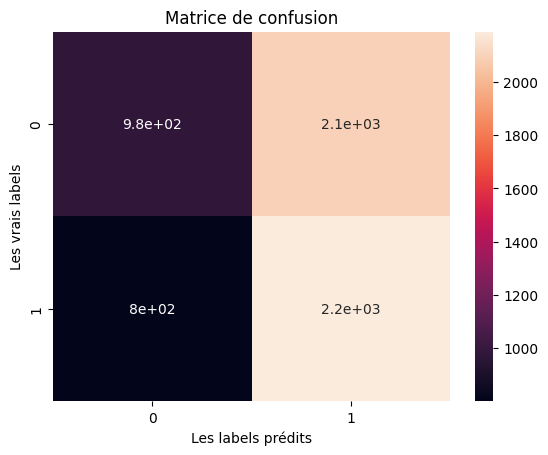

In [28]:
cm = confusion_matrix(validation_data_y,predictions)
#représentation graphique du résultat du meilleure model
sns.heatmap(cm, annot=True)
plt.xlabel('Les labels prédits')
plt.ylabel('Les vrais labels')
plt.title('Matrice de confusion')
plt.show()

In [29]:
#we print the percentage of True Positive, True Negative, False Positive and False Negative
tn, fp, fn, tp = cm.ravel()
total_samples = tn + fp + fn + tp
true_negative_percentage = (tn / total_samples) * 100
false_positive_percentage = (fp / total_samples) * 100
false_negative_percentage = (fn / total_samples) * 100
true_positive_percentage = (tp / total_samples) * 100

print(f"True Negative: {true_negative_percentage}%")
print(f"False Positive: {false_positive_percentage}%")
print(f"False Negative: {false_negative_percentage}%")
print(f"True Positive: {true_positive_percentage}%")

True Negative: 16.09442060085837%
False Positive: 34.56586332122813%
False Negative: 13.222185539782105%
True Positive: 36.1175305381314%


On peut donc conlure que notre modèle est très bon à prédire les faux positives et les vrai positives. Ce modèle est donc biaisé. Il n'est pas en mesure de correctement prédire les valeurs

# Conclusion

l'algorithme Passive-Aggressive dans ce contexte montre des limites considérables, notamment une difficulté à généraliser sur de nouveaux datasets. Cela peut être dû à plusieurs facteurs comme l'insuffisance du modèle pour traiter des features complexes des données textuelles, ou peut-être le modèle nécessite un réglage plus fin des paramètres ou l'utilisation d'une approche de feature engineering plus sophistiquée. Il serait interessant de tester d'autres modèles.

## L'utilisation du vrAI

In [ ]:
vrAI = 0
acc = accuracy 
if acc > 0.90:
    vrAI = 'A'
elif  0.70<acc<=0.90:
    vrAI = 'B'
elif  0.50<acc<=0.70:
    vrAI = 'C'
elif  0.30<acc<=0.50:
    vrAI = 'D'
elif  0.15<acc<=0.30:
    vrAI = 'E'
elif  0.05<acc<=0.15:
    vrAI = 'F'
else:
    vrAI = 'Fx'